# Overview

The Residual Attention Network is a convolutional neural network that uses attention mechanisms. Attention Modules to generate attention-aware features. Each contains a bottom-up top-down feedforward structure to unfold the feedforward and feedback attention process, into a single feedforward process.

Attention not only serves to select a focused location but also enhances different representations of objects at that location. It uses top information to guide bottom up feedforward processes. In lieu of a query and query context to assist each other in their work, the information source here (image) is split into two different ones and combined repeatedly. Residual learning is applied to alleviate the problem brought by repeated splitting and sampling.

This model utilises soft attention.

> In their paper, soft attention is **when we calculate the context vector as a weighted sum of the encoder hidden states**. Hard attention is when, instead of weighted average of all hidden states, we use attention scores to select a single hidden state
>

## Novel Contributions

### Stacked Network Structure

The Residual Attention Network is constructed by stacking multiple Attention Modules. This is the basic application of mixed attention mechanism and thus different types of attention are able to be captured in different Attention Modules.

### Attention Residual Learning

Stacking Attention Modules directly would lead to performance drop. Attention residual learning mechanisms would help to optimise very deep Residual Attention Networks with hundreds of layers.

### Bottom-Up Top-Down Feedforward Attention

This structure is used as part of the Attention Module to add soft weights on features. The structure mimics bottom-up fast feed forwards process and top-down attention feedback in a single feedforward process which allows an end-to-end trainable network with top-down attention.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def load_train_valid_sets(data_dir='./data', valid_split=0.1, batch_size=8):
    
    transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    trainset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=True, download=True)
    
    
    train_size = int(len(trainset)*(1 - valid_split))
    valid_size = len(trainset) - train_size
    train, valid = torch.utils.data.random_split(trainset, [train_size, valid_size])
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
    
    classes = {k : trainset.classes[k] for k in range(len(trainset.classes))}
    
    return train_loader, valid_loader, classes

In [3]:
def load_test_sets(data_dir='./data', batch_size=8):
    
    transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    testset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=False, download=True)
    
    
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

    return test_loader

In [4]:
train_loader, valid_loader, classes = load_train_valid_sets()

Files already downloaded and verified


In [5]:
test_loader = load_test_sets()

Files already downloaded and verified


# Residual Attention Network

## Attention Module

Each attention module is divided into two branches:

- Mask Branch: Uses bottom-up top-down structure to learn the same size mask $M(x)$ that softly weight output features $T(x)$. The output mask is used as control games for neurons of trunk branch.
- Trunk Branch : Performs feature processing and can be adapted to any state of the art network structures. E.g. Pre-activation Resisdual Unit, ResNeXt and Inception.

The output of the Attention Module is:

$$
H_{i,c}(x) = M_{i,c}(x)*T_{i,c}(x)
$$

where $i$ ranges over all spatial positions and $x \in {1,...,C}$ is the index of the channel. The whole structure can be trained end-to-end.

The attention mask serves as a feature selector during forward inference and as a gradient update filter during back propagation. In the soft mask branch, the gradient of the mask for input feature is:

$$
\frac{\partial M(x,\theta)T(x,\phi)}{\partial\phi} = M(x,\theta)\frac{\partial T(x,\phi)}{\partial\phi}
$$

where $\theta, \phi$ are the mask branch parameters and trunk branch parameters respectively. This makes the Attention Modules robust to noisy labels. The mask branches can prevent wrong gradients (from noisy labels) to update trunk parameters.

Due to images with clutter background, complex scenes and large appearance variations, these need to me modelled by different types of attentions and features from different layers need to be modelled by different attention masks.

Using a single mask branch:

- Requires an exponential number of channels to capture all the combinations of different factors.
- Only modifies the features once, so if the modification fails on some parts of the image then the following network modules do not get a second chance.

These problems are alleviated using Residual Attention Network. Each trunk branch has its own mask branch to learn attention that is specialised for its features.

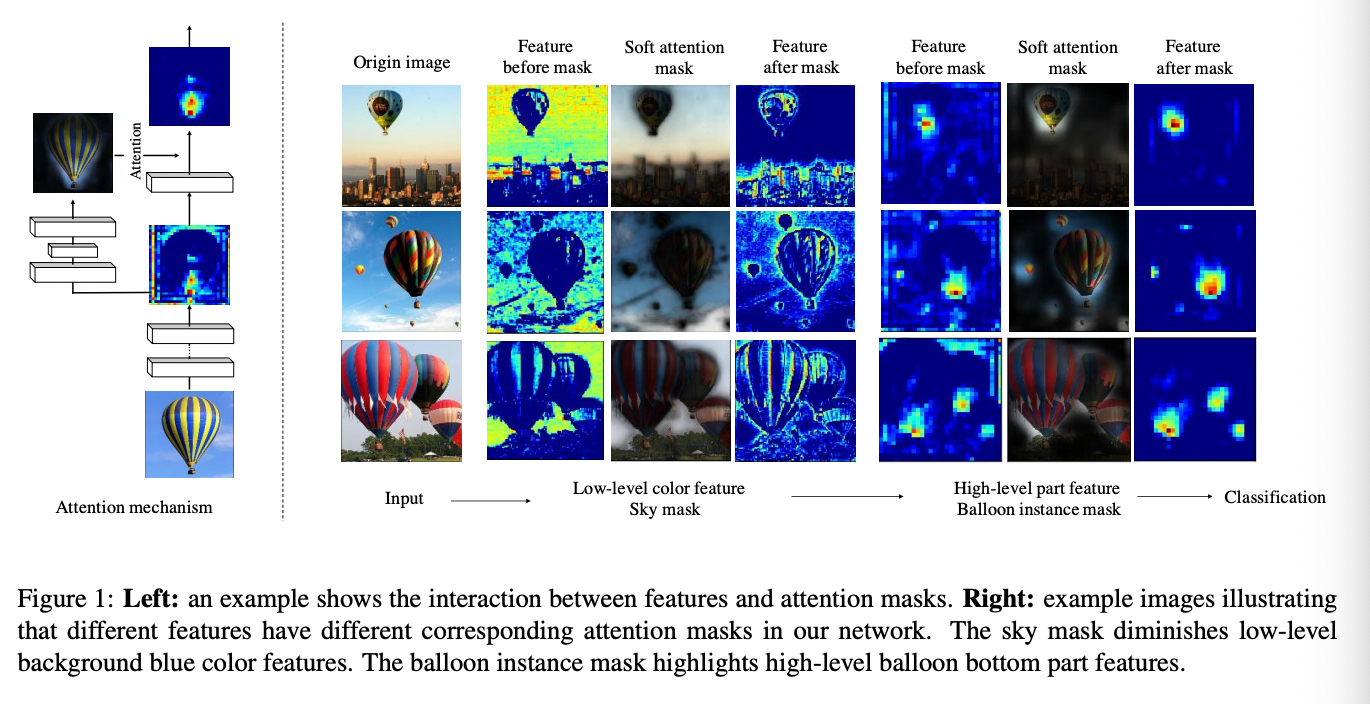

## Attention Residual Learning

The performance drop of stacking Attention Modules may drop via:

- Degradation of feature values in deep layers due to the dot product with mask.
- Soft mask can potentially break good property of trunk branch, for example the identical mapping of the Residual Unit.

Attention residual learning can ease thee problems. If the soft mask unit can be constructed as identical mapping, the performances should be no worse than its counterpart without attention. Therefore the output of the attention module becomes:

$$
H_{i,c}(x) = (1 + M_{i,c}(x))*T_{i,c}(x)
$$

$M(x)$ ranges from $[0,1]$. When $M(x)$ approximates 0, then $H(x)$ will approximate the original features $F(x)$. This is attention residual learning.

In the original ResNet, residual learning is formulated as:

$$
H_{i,c}(x) = x+F_{i,c}(x)
$$

where $F_{i,c}(x)$ approximates the residual function. In attention residual learning,  $F_{i,c}(x)$ indicates the features generated by deep convolutional networks. $M(x)$ mask branches work as feature selectors which enhance good features and suppress noise from the trunk features. 

Attention residual learning can keep good properties of original features but also gives them the ability to bypass soft mask branch and forward to top layers to weaken the mask branch’s feature selection ability.


# Architecture

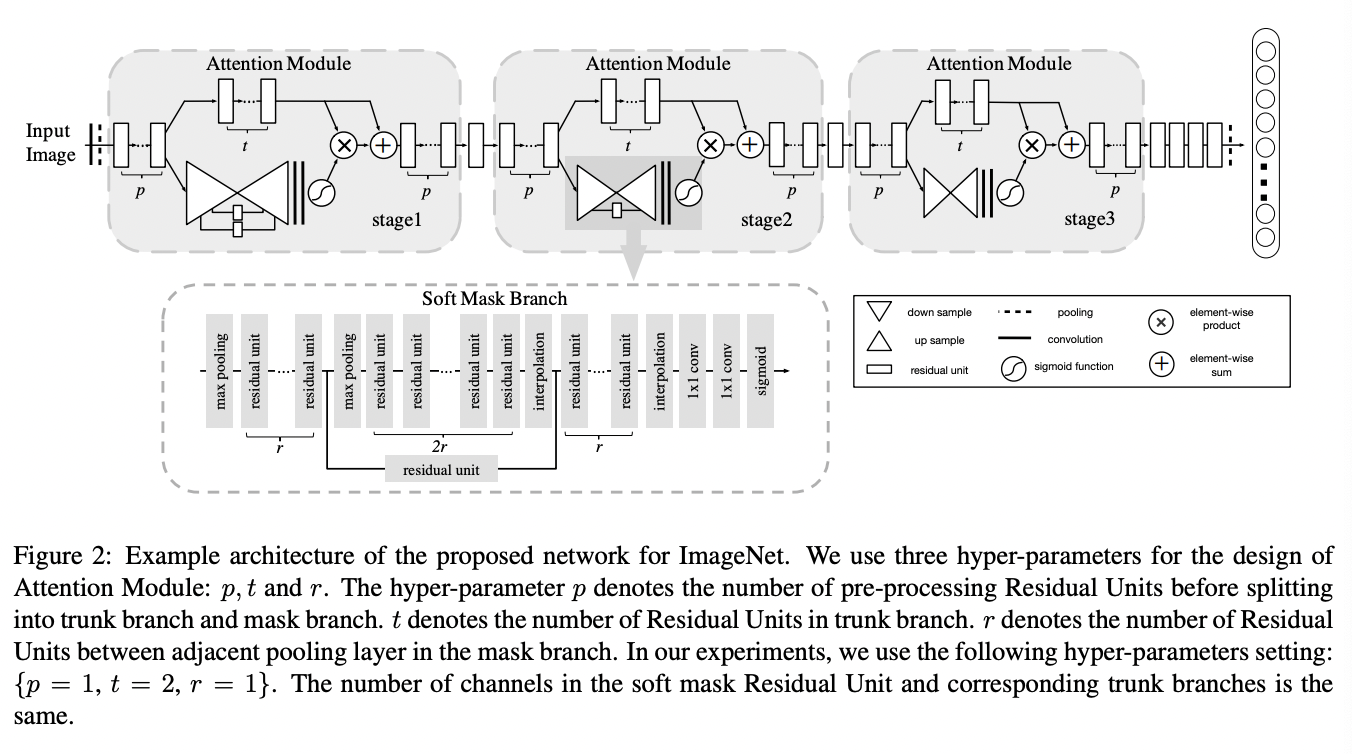


## Soft Mask Branch

The mask branch contains:

- Fast feed-forward sweep which quickly collects global information of the whole image.
- Top-down feedback steps which combine global information with original feature maps.

From input, max pooling is performed several times to increase the receptive field rapidly after a small number of Residual Units. After reaching the lowest/bottleneck resolution, the global information is then expanded by a symmetrical top-down architecture to guide input features in each position.

Linear interpolation up samples the output after some residual units. The number of bilinear interpolation layers is the same as the max pooling layers to keep the output size the same as the input feature map. Then a sigmoid layer normalises the output to between [0,1], after two consecutive 1x1 convolution layers.

Skip connections are also added between bottom up and top down parts to capture information from different scales.
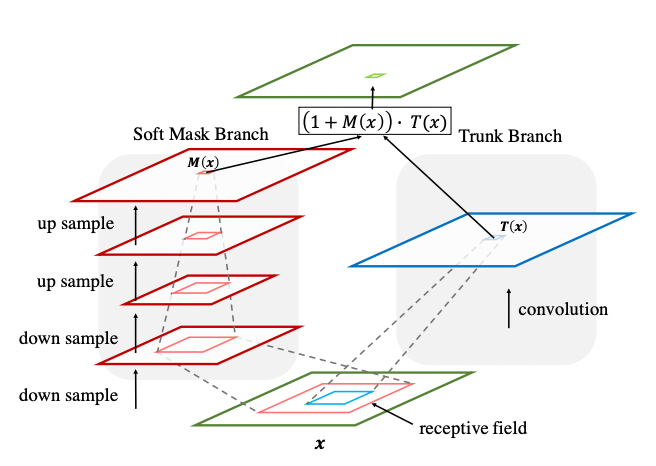 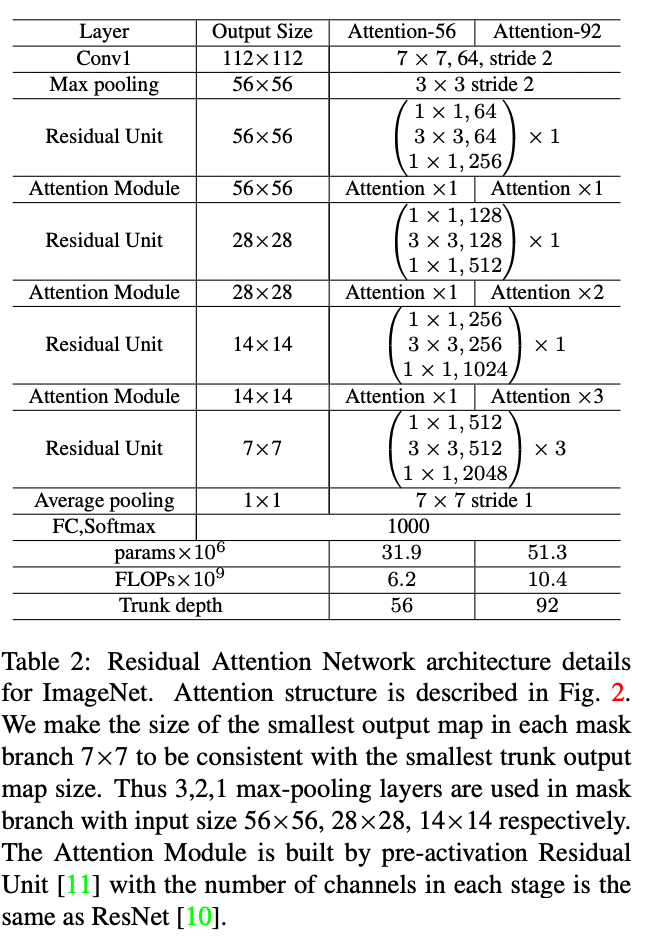

In [6]:
class ConvUnit(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, relu=True, **kwargs):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.norm = torch.nn.BatchNorm2d(out_channels)
        
        if relu:
            self.relu = torch.nn.ReLU()
        else:
            self.relu = torch.nn.Sequential()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [7]:
class ResUnit(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, relu=True, **kwargs):
        super().__init__()
        self.shortcut = ConvUnit(in_channels, out_channels, 1, **kwargs)
        
        self.conv1 = ConvUnit(in_channels, out_channels//4, 1, padding=1)
        self.conv2 = ConvUnit(out_channels//4, out_channels//4, 3, **kwargs)
        self.conv3 = ConvUnit(out_channels//4, out_channels, 1, relu=False)
        
        if relu:
            self.relu = torch.nn.ReLU()
        else:
            self.relu = torch.nn.Sequential()
        
        
    def forward(self, x):
        shortcut = self.shortcut(x)
        res = self.conv1(x)
        res = self.conv2(res)
        res = self.conv3(res)
        
        x = res + shortcut
        x = self.relu(x)
        
        return x

In [8]:
class SoftMaskBranch(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, encoder_depth, **kwargs):
        super().__init__()
        self.pool = torch.nn.MaxPool2d(3,2, padding=1)
        self.r = ResUnit(in_channels, out_channels)
        self.upsample = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv = ConvUnit(in_channels, out_channels, 1)
        self.sigmoid = torch.nn.Sigmoid()

        self.depth = encoder_depth
        
    def forward(self, x):
        res_out = []
        
        for i in range(self.depth):
            x = self.pool(x)
            x = self.r(x)
            if i < self.depth - 1:
                res_out.append(x)
        
        for j in reversed(range(self.depth)):
            if j < self.depth - 1:
                x = x + res_out[j]
                
            x = self.r(x)
            x = self.upsample(x)
            
        x = self.conv(x)
        x = self.conv(x)
        x = self.sigmoid(x)
        
        return x

In [9]:
class AttentionModule(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, encoder_depth, **kwargs):
        super().__init__()
        
        self.preprocess = torch.nn.Sequential(
            ResUnit(in_channels, out_channels, **kwargs)
        )
        
        self.trunk = torch.nn.Sequential(
            ResUnit(in_channels, out_channels),
            ResUnit(in_channels, out_channels)
        )
        
        self.mask = torch.nn.Sequential(
            SoftMaskBranch(in_channels, out_channels, encoder_depth)
        )
        
    
    def forward(self, x):
        x = self.preprocess(x)
        trunk_out = self.trunk(x)
        mask_out = self.mask(x)
        prod = torch.mul(trunk_out, mask_out)
        x = trunk_out + prod
        x = self.preprocess(x)
        
        
        return x

In [10]:
64*32

2048

In [11]:
class Attention56(torch.nn.Module):
    
    def __init__(self, shape=(224, 224,3), n_channels=64, num_classes=10):
        super().__init__()
        
        self.conv1 = ConvUnit(3, n_channels, 7, stride=2, padding=3)#64x112x112
        self.pool1 = torch.nn.MaxPool2d(3, 2, padding=1) # 64x56x56
        
        self.res1 = ResUnit(n_channels, n_channels * 4) # 256x56x56
        self.am1 = AttentionModule(n_channels * 4, n_channels * 4, 3) # 256x56x56
        
        self.res2 = ResUnit(n_channels * 4, n_channels * 8, stride=2) # 512x28x28
        self.am2 = AttentionModule(n_channels * 8, n_channels * 8, 2) # 512x28x28
        
        self.res3 = ResUnit(n_channels * 8, n_channels * 16, stride=2) # 1024x14x14
        self.am3 = AttentionModule(n_channels * 16, n_channels * 16, 1) # 1024x14x14
        
        self.res4 = torch.nn.Sequential(
            ResUnit(n_channels * 16, n_channels * 32, stride=2), # 2048x7x7
            ResUnit(n_channels * 32, n_channels * 32), # 2048x7x7
            ResUnit(n_channels * 32, n_channels * 32), # 2048x7x7
        )
            

        self.gap = torch.nn.Sequential(
              torch.nn.AvgPool2d(7,1) # 2048x1x1
        )
        
        self.fc = torch.nn.Sequential(
              torch.nn.Linear(n_channels * 32, num_classes)
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.res1(x)
        x = self.am1(x)
        x = self.res2(x)
        x = self.am2(x)
        x = self.res3(x)
        x = self.am3(x)
        x = self.res4(x)
        x = self.gap(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x

# Details of Learning

| Element | Description |
| --- | --- |
| Data Prep | Images are resized to 224x224 and randomly augmented with per-pixel mean subtracted. For CIFAR-10 and CIFAR-100 analysis, the images are padded to 40x40 and then a random 32x32 crop is taken, or its horizontal flip. Total 60,000 images, where 10,000 are test images. |
| Normalisation | Batch normalisation is applied after each convolution and before activation. |
| Batch Size | 64 |
| Solver | SGD(learning_rate=0.1/10 at 64k and 96k iterations , weight_decay=0.0001, momentum=0.9) |
| Epochs | 160 000 iterations |

In [12]:
import torch.optim as optim
import time

learning_rate = 0.01

net = Attention56(len(classes)).to(device)

critereon = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)

In [13]:
class Summary:
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def all_reduce(self):
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
        total = torch.tensor([self.sum, self.count], dtype=torch.float32, device=device)
        dist.all_reduce(total, dist.ReduceOp.SUM, async_op=False)
        self.sum, self.count = total.tolist()
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
    def summary(self):
        fmtstr = ''
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)
        
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))
        
    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        print(' '.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [14]:
def train(train_loader, model, criterion, optimizer, epoch, device, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        # move data to the same device as model
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args['print_freq'] == 0:
            progress.display(i + 1)
    
    return model, progress
            
            
    

In [ ]:
args = {'print_freq':10}
model, progress = train(train_loader, net, critereon, optimizer, 1, device, args)

Epoch: [1][   1/5625]	Time 14.192 (14.192)	Data  0.008 ( 0.008)	Loss 2.4802e+00 (2.4802e+00)	Acc@1   0.00 (  0.00)	Acc@5  37.50 ( 37.50)
Epoch: [1][  11/5625]	Time 15.337 (14.889)	Data  0.007 ( 0.007)	Loss 5.1216e+00 (3.1259e+00)	Acc@1   0.00 (  9.09)	Acc@5  62.50 ( 47.73)
Epoch: [1][  21/5625]	Time 15.386 (14.987)	Data  0.007 ( 0.008)	Loss 2.2906e+00 (3.5643e+00)	Acc@1  25.00 (  7.74)	Acc@5  50.00 ( 42.86)
Epoch: [1][  31/5625]	Time 15.142 (15.007)	Data  0.007 ( 0.008)	Loss 3.2023e+00 (3.3628e+00)	Acc@1   0.00 ( 10.89)	Acc@5  50.00 ( 44.76)
Epoch: [1][  41/5625]	Time 15.098 (15.012)	Data  0.007 ( 0.008)	Loss 3.1388e+00 (3.3168e+00)	Acc@1   0.00 ( 10.37)	Acc@5  37.50 ( 46.34)
Epoch: [1][  51/5625]	Time 15.204 (15.020)	Data  0.007 ( 0.008)	Loss 2.2973e+00 (3.2532e+00)	Acc@1  25.00 ( 10.54)	Acc@5  75.00 ( 47.06)
Epoch: [1][  61/5625]	Time 15.072 (14.989)	Data  0.007 ( 0.008)	Loss 2.4531e+00 (3.1730e+00)	Acc@1  12.50 ( 10.45)	Acc@5  37.50 ( 48.36)
Epoch: [1][  71/5625]	Time 14.830 (14.935

Epoch: [1][ 601/5625]	Time 13.854 (14.456)	Data  0.007 ( 0.009)	Loss 2.4976e+00 (2.3801e+00)	Acc@1   0.00 ( 14.58)	Acc@5  50.00 ( 62.19)
Epoch: [1][ 611/5625]	Time 13.827 (14.447)	Data  0.008 ( 0.009)	Loss 2.2787e+00 (2.3799e+00)	Acc@1  12.50 ( 14.44)	Acc@5  62.50 ( 62.19)
Epoch: [1][ 621/5625]	Time 14.547 (14.440)	Data  0.007 ( 0.009)	Loss 2.0535e+00 (2.3779e+00)	Acc@1  25.00 ( 14.49)	Acc@5  75.00 ( 62.20)
Epoch: [1][ 631/5625]	Time 14.266 (14.436)	Data  0.007 ( 0.009)	Loss 2.1270e+00 (2.3760e+00)	Acc@1  25.00 ( 14.54)	Acc@5  87.50 ( 62.28)
Epoch: [1][ 641/5625]	Time 14.289 (14.440)	Data  0.008 ( 0.009)	Loss 2.2733e+00 (2.3739e+00)	Acc@1   0.00 ( 14.51)	Acc@5  75.00 ( 62.34)
Epoch: [1][ 651/5625]	Time 14.880 (14.439)	Data  0.010 ( 0.009)	Loss 1.9485e+00 (2.3699e+00)	Acc@1  50.00 ( 14.65)	Acc@5  62.50 ( 62.46)
Epoch: [1][ 661/5625]	Time 14.361 (14.443)	Data  0.008 ( 0.009)	Loss 1.9288e+00 (2.3671e+00)	Acc@1  37.50 ( 14.71)	Acc@5  75.00 ( 62.59)
Epoch: [1][ 671/5625]	Time 14.821 (14.451

Epoch: [1][1201/5625]	Time 14.996 (14.599)	Data  0.010 ( 0.009)	Loss 2.1703e+00 (2.2575e+00)	Acc@1  37.50 ( 17.10)	Acc@5  62.50 ( 67.15)
Epoch: [1][1211/5625]	Time 15.270 (14.607)	Data  0.010 ( 0.009)	Loss 1.9600e+00 (2.2562e+00)	Acc@1  25.00 ( 17.16)	Acc@5  87.50 ( 67.19)
Epoch: [1][1221/5625]	Time 16.811 (14.612)	Data  0.009 ( 0.009)	Loss 1.9838e+00 (2.2547e+00)	Acc@1  12.50 ( 17.16)	Acc@5 100.00 ( 67.31)
Epoch: [1][1231/5625]	Time 14.655 (14.616)	Data  0.010 ( 0.009)	Loss 2.1670e+00 (2.2539e+00)	Acc@1  25.00 ( 17.18)	Acc@5  50.00 ( 67.33)


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
        
        if i % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, 100 * correct / total))

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

In [ ]:
import numpy as np
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape
    
    if allkernels:
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3:
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.ioff()
    plt.show()